In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CustomCNN(tf.Module):
    def __init__(self,name=None):
        super().__init__(name=name)
        
        self.inicial = tf.initializers.lecun_uniform(seed=1)
        
                #Encoder
        #128x128                                                (H,W,Cin,Cout)
        self.LayerE_1_Weights_Filter = tf.Variable(self.inicial((3,3,3,16)))
        self.LayerE_1_Bias= tf.Variable(self.inicial((16,)))
        #64x64
        self.LayerE_2_Weights_Filter = tf.Variable(self.inicial((3,3,16,8)))
        self.LayerE_2_Bias= tf.Variable(self.inicial((8,)))
        #32x32
        self.LayerE_3_Weights_Filter = tf.Variable(self.inicial((3,3,8,8)))
        self.LayerE_3_Bias= tf.Variable(self.inicial((8,)))
        #16x16
                #Decoder
        self.LayerD_3_Weights_Filter = tf.Variable(self.inicial((2,2,8,8)))
        self.LayerD_3_Bias= tf.Variable(self.inicial((8,)))

        self.LayerD_2_Weights_Filter = tf.Variable(self.inicial((2,2,8,8)))
        self.LayerD_2_Bias= tf.Variable(self.inicial((8,)))

        self.LayerD_1_Weights_Filter = tf.Variable(self.inicial((2,2,8,8)))
        self.LayerD_1_Bias= tf.Variable(self.inicial((8,)))

        self.LayerD_0_Weights_Filter = tf.Variable(self.inicial((3,3,3,8)))

    def Conv2D(self,x,W,b,strides1=1):
        x=tf.nn.conv2d(x,W,strides=[1,strides1,strides1,1],padding='SAME')
        x=tf.nn.bias_add(x,b)
        x=tf.nn.relu(x)
        return x

    def MaxPool(self,x,k=2):
        return tf.nn.max_pool(x,ksize=[1,k,k,1],
                                strides=[1,k,k,1],
                                padding='SAME')
    
    #@tf.function
    def __call__(self,x,Batch):

        img=tf.cast(x,tf.float32)
        #128x128
        
        L1=self.Conv2D(img,self.LayerE_1_Weights_Filter,self.LayerE_1_Bias)
        L1=self.MaxPool(L1)

        #64x64
        L2=self.Conv2D(L1,self.LayerE_2_Weights_Filter,self.LayerE_2_Bias)
        L2=self.MaxPool(L2)

        #32x32
        L3=self.Conv2D(L2,self.LayerE_3_Weights_Filter,self.LayerE_3_Bias)
        ENCODED=self.MaxPool(L3)

        D1 = tf.nn.conv2d_transpose(ENCODED,
                                    self.LayerD_3_Weights_Filter, 
                                    tf.constant([Batch,16,16,8]),
                                    strides=[1,1,1,1],padding='SAME')  
        D1 = tf.add(D1, self.LayerD_3_Bias)
        D1 = tf.nn.relu(D1)
        D1 = tf.keras.layers.UpSampling2D((2,2))(D1)

        D2 = tf.nn.conv2d_transpose(D1,self.LayerD_2_Weights_Filter, 
                                    tf.constant([Batch,32,32,8]),
                                    strides=[1,1,1,1],padding='SAME')  
        D2 = tf.add(D2, self.LayerD_2_Bias)
        D2 = tf.nn.relu(D2)
        D2 = tf.keras.layers.UpSampling2D((2,2))(D2)

        D3 = tf.nn.conv2d_transpose(D2,self.LayerD_1_Weights_Filter, 
                                    tf.constant([Batch,64,64,8]),
                                    strides=[1,1,1,1],padding='SAME')  
        D3 = tf.add(D3, self.LayerD_1_Bias)
        D3 = tf.nn.relu(D3) 
        D3 = tf.keras.layers.UpSampling2D((2,2))(D3)
        DECODED=tf.nn.conv2d_transpose(D3,self.LayerD_0_Weights_Filter, 
                                     tf.constant([Batch,128,128,3]),
                                     strides=[1,1,1,1],padding='SAME') 
        DECODED = tf.nn.sigmoid(DECODED)
        return DECODED

In [ ]:
AUTOENCODER = CustomCNN(name="AUTOENCODER")

In [ ]:
a=np.ones((1,128,128,3))

In [ ]:
AUTOENCODER(a,1)

<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[0.58241993, 0.43080163, 0.3399713 ],
         [0.6490371 , 0.40967113, 0.2939547 ],
         [0.6490391 , 0.40967256, 0.29395497],
         ...,
         [0.6245082 , 0.41667616, 0.31081772],
         [0.6259293 , 0.41647062, 0.30824423],
         [0.5376649 , 0.42061958, 0.37055594]],

        [[0.5218316 , 0.4852026 , 0.49054718],
         [0.6384275 , 0.4365295 , 0.41891697],
         [0.6384288 , 0.43652815, 0.41891414],
         ...,
         [0.6359478 , 0.45433396, 0.41652796],
         [0.637603  , 0.45212638, 0.41230413],
         [0.558112  , 0.44549742, 0.43681577]],

        [[0.5218314 , 0.48520285, 0.4905484 ],
         [0.6384272 , 0.4365309 , 0.4189163 ],
         [0.63842875, 0.43653008, 0.41891378],
         ...,
         [0.633931  , 0.45897254, 0.40990543],
         [0.63383317, 0.4572316 , 0.41047582],
         [0.5468348 , 0.45127735, 0.4309485 ]],

        ...,

        [[0.51453906, 0.4836003 , 

In [ ]:
optimizador = tf.compat.v1.train.AdamOptimizer()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')


In [ ]:
@tf.function
def train_step(model,tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata,len(tdata))

        x = tf.cast(labels, tf.float32)
        img = tf.reshape(x, shape=[-1, 128, 128, 3])
        loss_funct = tf.math.squared_difference
        loss = tf.reduce_mean(loss_funct(img, predictions))
   
    gradients = tape.gradient(loss, model.trainable_variables)
    capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)
    train_loss(loss)

In [ ]:
@tf.function
def test_step(model,tdata, labels):
    predictions = model(tdata,len(tdata))
    x = tf.cast(labels, tf.float32)
    img = tf.reshape(x, shape=[-1, 128, 128, 3])
    loss_funct = tf.math.squared_difference
    t_loss = tf.reduce_mean(loss_funct(img, predictions))

    test_loss(t_loss)

In [ ]:
feature_map = {
    'image': tf.io.FixedLenFeature(shape=[], dtype=tf.string)
}
def read_tf_record(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = tf.image.decode_image(example['image'], channels=3)
    return image


def get_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(read_tf_record)
    return dataset


In [ ]:
def fitting(model,EPOCHS,batch_size,train_files,val_files):
    Train_L = []
    Test_L = []
    for epoch in tqdm.tqdm(range(EPOCHS)):
        for file_tfrec in train_files[0:10]:
            x_train=np.array(list(get_dataset(file_tfrec).as_numpy_iterator()))
            i=0
            end=0
            while end<len(x_train):
                start = i*batch_size
                end = start+batch_size
                batch_x = np.array(x_train[start:end])/255.0
                batch_y = np.array(x_train[start:end])/255.0
                train_step(model,batch_x,batch_y)
                
                i+=1
        x_val=np.array(list(get_dataset(val_files).as_numpy_iterator()))/255.0
        test_step(model,x_val[0:500],x_val[0:500])

        
        if epoch%5==0:
            template = 'Epoch {}, Perdida: {}, Perdida de prueba: {}'
            print(template.format(epoch+1,
                                train_loss.result(),
                                test_loss.result()))
            plt.figure(figsize=(10,10))
            plt.subplot(1,2,1)
            original_img=x_val[0]
            plt.imshow(original_img)
            plt.title("Imagen Original")
            plt.subplot(1,2,2)
            rec_img=model(np.expand_dims(original_img,axis=0),1)
            plt.imshow(rec_img[0].numpy())
            plt.title("Imagen Reconstruida")
            plt.show()

        Train_L.append(train_loss.result())
        Test_L.append(test_loss.result())

        train_loss.reset_states()
        test_loss.reset_states()
    return Train_L,Test_L

In [ ]:
path="/content/drive/MyDrive/Dataset/Simpson/data_tfrec/"
batch_files=glob.glob(path+"*.tfrec")
train_val_files,test_files=train_test_split(batch_files,test_size=0.1)
train_files,val_files=train_test_split(train_val_files,train_size=0.95)

In [ ]:
print(val_files)

['/content/drive/MyDrive/Dataset/Simpson/data_tfrec/simpson_data_05.tfrec']


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1, Perdida: 0.04746434837579727, Perdida de prueba: 0.027898306027054787


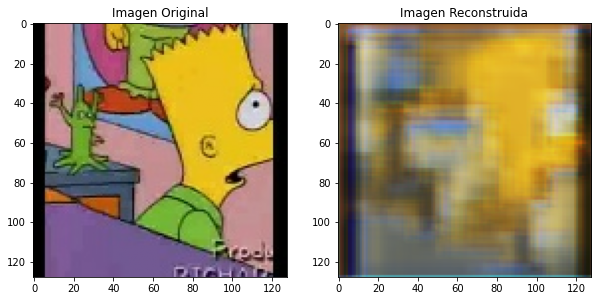

 20%|██        | 5/25 [01:31<05:59, 17.96s/it]

Epoch 6, Perdida: 0.017018890008330345, Perdida de prueba: 0.016586260870099068


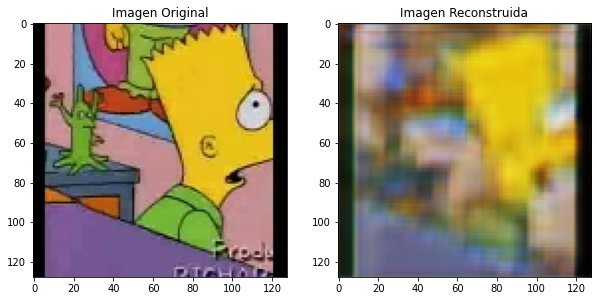

 40%|████      | 10/25 [02:58<04:21, 17.40s/it]

Epoch 11, Perdida: 0.013871137984097004, Perdida de prueba: 0.013892650604248047


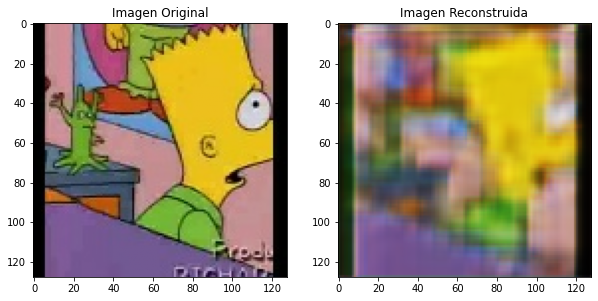

 60%|██████    | 15/25 [04:23<02:50, 17.03s/it]

Epoch 16, Perdida: 0.012918834574520588, Perdida de prueba: 0.013165516778826714


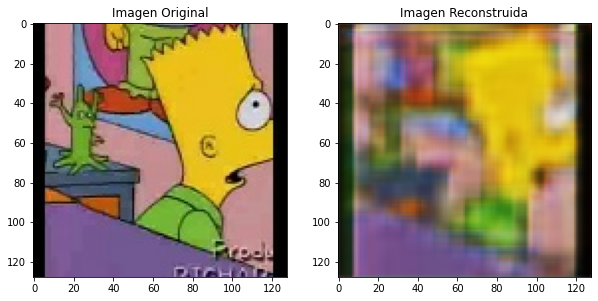

 80%|████████  | 20/25 [05:48<01:24, 16.99s/it]

Epoch 21, Perdida: 0.0122751509770751, Perdida de prueba: 0.012555178254842758


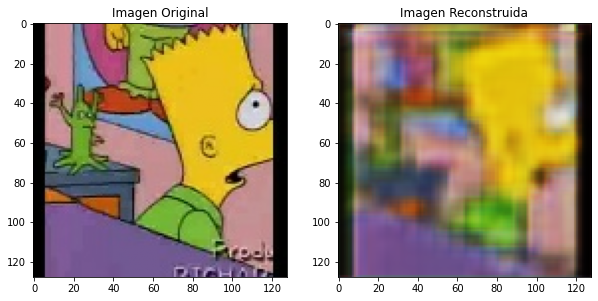

100%|██████████| 25/25 [07:14<00:00, 17.36s/it]


In [ ]:
Train_L,Test_L=fitting(model=AUTOENCODER,
                       EPOCHS=25,
                       batch_size=128,
                       train_files=train_files,
                       val_files=val_files)

Text(0.5, 1.0, 'Results')

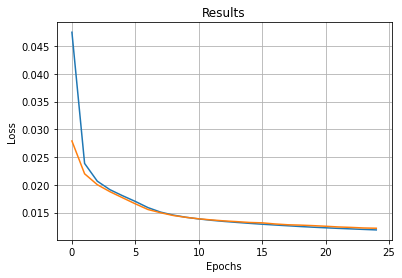

In [ ]:
plt.plot(Train_L)
plt.plot(Test_L)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Results")

In [ ]:
x_test=np.array(list(get_dataset(test_files).take(10).as_numpy_iterator()))/255.0
x_predict=AUTOENCODER(x_test,10)

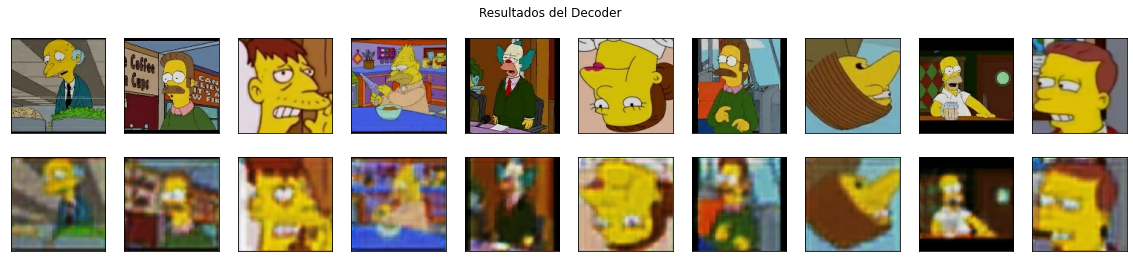

In [ ]:
n=10
plt.figure(figsize=(20, 4))
plt.suptitle("Resultados del Decoder")
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_predict[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
!nvidia-smi

Mon Oct 31 21:00:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    29W /  70W |   8058MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Guardar model
Guardar_Modelo = True #@param {type:"boolean"}
if Guardar_Modelo==True:
    tf.saved_model.save(AUTOENCODER, "AUTOENCODER_MAGZ")

In [ ]:
!cp -R /content/AUTOENCODER_MAGZ /content/drive/MyDrive/Dataset/Simpson/